# Assessing Research Output and Impact: A Decade of Scholarly Contributions from LSE's Economics Department (2013-2022)

### Candidate Number: 43899

## Introduction

### Overview

In this data analysis research project, I aim to examine the research output of the LSE Economics department from 2013 to 2022. The main goal is to understand the trends, impact, and overall scholarly contributions of the department during this period. By focusing on the Economics department, I seek to explore the academic significance of one of LSE's most prominent fields of study. This analysis is comprised of 4 parts: 

- *Section 1*: Research Questions and Motivations 
- *Section 2*: Data Description and Processing 
- *Section 3*: Exploratory Data Analysis (EDA)
- *Section 4*: Insights, Limitations and Conclusions


## Section 1: Research Questions and Motivations 

The primary research questions addressed in this project are as follows:

1. What is the volume and growth of research output from LSE's Economics department between 2013 and 2022?
2. What are the trends in the distribution of citations and number of publications for the Economics department's publications?
3. Who are the main contributors to LSE Economics' research output? Are there members of staff that are particularly productive?

This research project is essential and useful for several reasons:

1. Academic Impact: Analyzing the research output of LSE's Economics department provides insights into the department's academic influence and its contribution to the field of economics. Understanding these trends can help LSE and other institutions make informed decisions about resource allocation, collaboration, and research focus.

2. Benchmarking: By assessing the research output and impact of LSE's Economics department, we can benchmark its performance against other departments within the institution and comparable departments at other universities. This benchmarking can inform strategies for maintaining or improving the department's standing in the academic community.

3. Stakeholder Engagement: This project's findings can serve as a valuable communication tool for LSE's Economics department when engaging with various stakeholders, including prospective students, current students, alumni, funding agencies, and potential collaborators. Sharing research output data and trends can showcase the department's achievements, impact, and dedication to advancing economic knowledge.

In summary, this research project seeks to provide valuable insights into the research output and impact of LSE's Economics department between 2013 and 2022. By understanding these trends and their implications, I hope to contribute to a more informed academic landscape and promote the continued success of the department and the wider institution.

## Section 2: Data Description and Processing

There are 2 main sources of data I used for this project: 

1. [LSE Research Online](https://eprints.lse.ac.uk/): This is institutional repository for the London School of Economics and Political Science. LSE Research Online contains data on research produced by LSE staff, including journal articles, book chapters, books, working papers, conference papers. 

2. [Scopus API](https://dev.elsevier.com/): The Scopus API is a powerful application programming interface (API) provided by Elsevier, which allows users to access and retrieve a wealth of research-related data from the extensive Scopus database. It enables researchers, developers, and institutions to query and extract bibliographic information, citation data, and author profiles programmatically, facilitating seamless integration with custom applications or data analysis projects.

My first step was to, from LSE Research Online, download the citation data for publications made by staff in the LSE Economics department. I did this using the 'advanced search' option on the LSE Research Online website to filter results. For simplicity, I only gathered citation data for published articles written between 2013-2022 inclusive. I manually downloaded .txt files containing BibTeX entries for all published articles by LSE Economics department staff for each year and added it to the folder titled 'data/EC_citations'. Each of these files is titled 'EC_XXXX' where XXXX stands for the year in which all the articles in the .txt file are published. 

My second step was to create a function in python that takes a year as an input, iterates over all the lines in the .txt file and returns lists containing the following information:
- Titles of all the articles published in this year 
- Publishing year 
- Names of the authors of the article 

Within this function, I also included some code that performs pre-processing on the data by using string manipulation to remove some punctuation from the titles. This is in order to ensure that the titles are syntactically suitable for submitting a query using the Scopus API. 

In [1]:
# Function to extract titles and authors 
def extract_titles_and_authors(year):
    filename = f'data/EC_citations/EC_{year}.txt'

    titles = []
    authors = []
    
    with open(filename, 'r', errors='replace') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("title"):
                title = line.split("{", 1)[1].rsplit("}", 1)[0]
                # Add a line to remove punctuation 
                title = title.replace("(", "").replace(")", "").replace("?", "").replace(":", "").replace("-", " ").replace(",", "").replace('"', "")
                titles.append(title)
            elif line.startswith("author") or line.startswith("editor"):
                author = line.split("{", 1)[1].rsplit("}", 1)[0]
                authors.append(author)
    
    pub_year = [year] * len(titles)


    return titles, pub_year, authors


My next step is to create a function that takes a title of a paper as an input, searches the Scopus database using an API request and parses the response to extract and return information about the number of search results and citation count for this paper. I limited the number of words in the title request to 10 in order to achieve greater accuracy with the search results. Successful API requests are ones that fulfill the following criteria: 
- The response status code is 200 (ie: a successful connection has been made) 
- The API request correctly identifies the paper I want to get information about (ie: there is one unique search result that matches the title of the paper I want to inquire about) 

Unsuccessful API requests are ones that do not fulfill one or both of these criteria. In order to distinguish between successful and unsuccessful API requests and filter only for the desired information, I introduced a system that codes requests based on whether they are successful or unsuccessful. The system works as follows: 
- If the API request failed, the value for search_results = -1 (unsuccessful) 
- If the API request was successful but there is more than one unique search result, the value for search_results = x where x is an integer such that x > 1 (unsuccessful) 
- If the API request was successful but there were no search results (because the article is not registered on the Scopus database), the value for search_results = 0 (unsuccessful)
- If the API request was successful but there is exactly one search result, the value for search_results = 1 (successful)

In [2]:
# Import necessary libraries 
import requests
import json 

# Define function to get search results and citations from an article title 
def get_search_results_and_cited_by_count(title, max_title_words = 10):
    
    # Clean title to make it suitable for API search   
    truncated_title = ' '.join(title.split()[:max_title_words])
    new_title = f'"{truncated_title}"'
    
    # Build API request
    api_key = '7f827d5f05bdb935cb391ba88889db23'
    base_url = 'https://api.elsevier.com/content/search/scopus'

    query = f'TITLE({new_title})'
    url = f'{base_url}?query={query}&apiKey={api_key}'

    headers = {
        'Accept': 'application/json',
    }

    response = requests.get(url, headers=headers)
    
    # Print error message if API request fails 
    if response.status_code != 200:
        search_results = -1
        cited_by_count = -1
    else:
        try:
            data = response.json()
            search_results = int(data['search-results']['opensearch:totalResults'])

            if search_results != 1:
                cited_by_count = 'invalid'
            else:
                cited_by_count = int(data['search-results']['entry'][0]['citedby-count'])

        except KeyError as e:
            print(f"KeyError occurred: {e}. The expected key is not present in the JSON response.")
            search_results = -1
            cited_by_count = -1

    return search_results, cited_by_count

The next step was to extract all the information about the papers and store them in a pandas DataFrame. First, I had to generate a pandas DataFrame to store all the information extracted using the functions defined above. Then, I created a list of years and iterated over it, using the integer year values as inputs to the function defined as 'extract_titles_and_authors' which returns 3 lists. I then iterated over each title in the list containing titles using the function 'get_search_results_and_cited_by_count' which outputs lists containing search results and citation counts for each title. At the end of this, for each year in my list of years I have 5 lists which I converted to a pd. DataFrame and concatenated to the DataFrame I created earlier titled 'papers_data'. I then filtered out the unsuccessful API requests, reset the indices and changed the datatype of the 'Citation Count' column until I had all the desired information in one DataFrame. 

In [3]:
# Create the dataframe 
import pandas as pd 

papers_data = pd.DataFrame(columns = ['Paper Title', 'Year of Publication', 'Authors', 'Search Results', 'Citation Count'])

# Created a test row entry 
papers_data.loc[0] = ['Sample Title', 2021, 'John Doe', 0, 5]

# List of years 
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Iterate over list of years 
for year in years:
    titles, pub_year, authors = extract_titles_and_authors(year)
    
    search = []
    citations = []
    
    for title in titles:
        search_results, cited_by_count = get_search_results_and_cited_by_count(title)
        search.append(search_results)
        citations.append(cited_by_count)
        
    new_data = pd.DataFrame(list(zip(titles, pub_year, authors, search, citations)), 
                                 columns=['Paper Title', 'Year of Publication', 'Authors', 'Search Results', 'Citation Count'])
    papers_data = pd.concat([papers_data, new_data], ignore_index=True)

    
# Filter out bad API requests and adjust and display final DataFrame
papers_data = papers_data[papers_data['Search Results'] == 1]
papers_data = papers_data.reset_index(drop=True)
papers_data['Citation Count'] = papers_data['Citation Count'].astype(int)
display(papers_data)
print(papers_data.info())


,Paper Title,Year of Publication,Authors,Search Results,Citation Count
0,Sample Title,2021,John Doe,0,5


,Paper Title,Year of Publication,Authors,Search Results,Citation Count
0,Trading partners and trading volumes implement...,2013,Joao Santos Silva and Silvana Tenreyro,1,49
1,Reference distributions and inequality measure...,2013,Frank A. Cowell and Emmanuel Flachaire and San...,1,3
2,Racial segregation patterns in selective unive...,2013,Peter Arcidiacono and Esteban Aucejo and Andre...,1,9
3,Equilibrium bids in sponsored search auctions ...,2013,Tilman Borgers and Ingemar Cox and Martin Pese...,1,34
4,The immobility of social tenants is it true Do...,2013,Youngha Cho and Christine M E Whitehead,1,7
...,...,...,...,...,...
520,Who sells during a crash Evidence from tax ret...,2022,Jeffrey L. Hoopes and Patrick Langetieg and St...,1,3
521,Does Rosie like riveting Male and female occup...,2022,Grace Lordan and Jorn-Steffen Pischke,1,5
522,Information theoretic approach to high dimensi...,2022,Chen Qiu and Taisuke Otsu,1,2
523,Nonparametric panel data regression with param...,2022,Alexandra Soberon and Juan M. Rodriguez-Poo an...,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Paper Title          525 non-null    object
 1   Year of Publication  525 non-null    int64 
 2   Authors              525 non-null    object
 3   Search Results       525 non-null    int64 
 4   Citation Count       525 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 20.6+ KB
None


## Section 3: Exploratory Data Analysis (EDA)

### Section 3.1 Frequency of publication

This section of the exploratory data analysis (EDA) focuses on understanding the distribution of publications from the LSE's Economics department between 2013 and 2022. The section starts by creating a countplot that displays the number of articles published in each year. This countplot provides a quick overview of the volume of research output each year, allowing the section to identify potential patterns or trends in the distribution of publications over time. The countplot also helps to compare the number of articles published each year, which can be valuable information for measuring the department's productivity and growth.

After examining the distribution of publications for each year, the section calculates the cumulative counts of articles published for each year. By creating a bar or line plot showing the cumulative distribution of articles published, the section aims to reveal the total growth in research output over the years. This cumulative distribution plot provides a broader view of the department's productivity and the changes in its research output over the years.

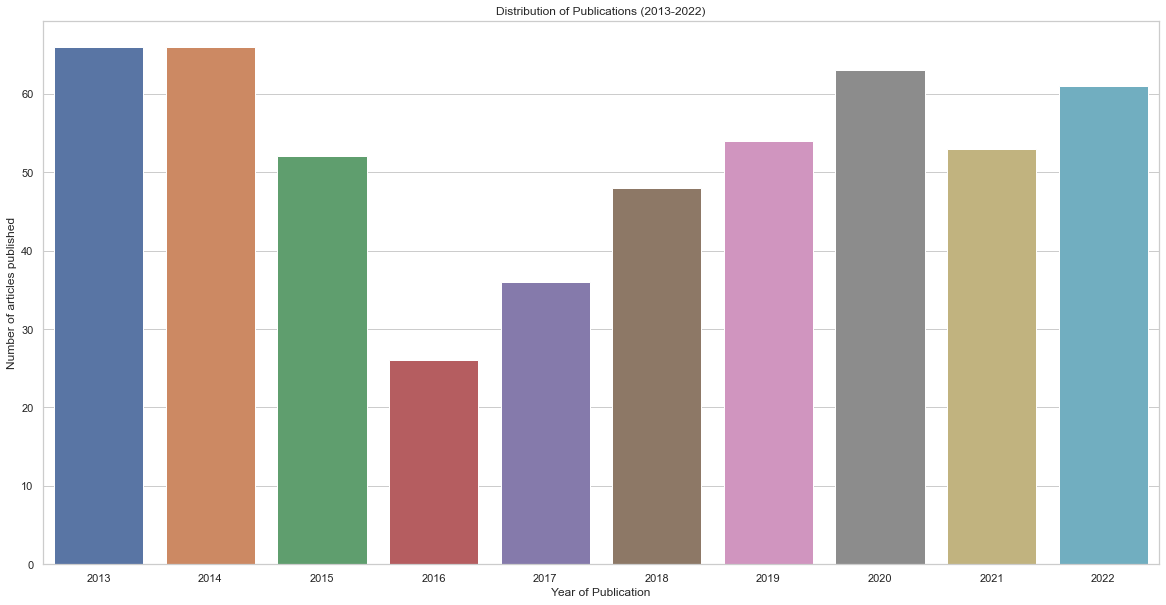

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(figsize=(20,10))
sns.countplot(data=papers_data, x='Year of Publication')
plt.title('Distribution of Publications (2013-2022)')
plt.ylabel('Number of articles published')
plt.show()

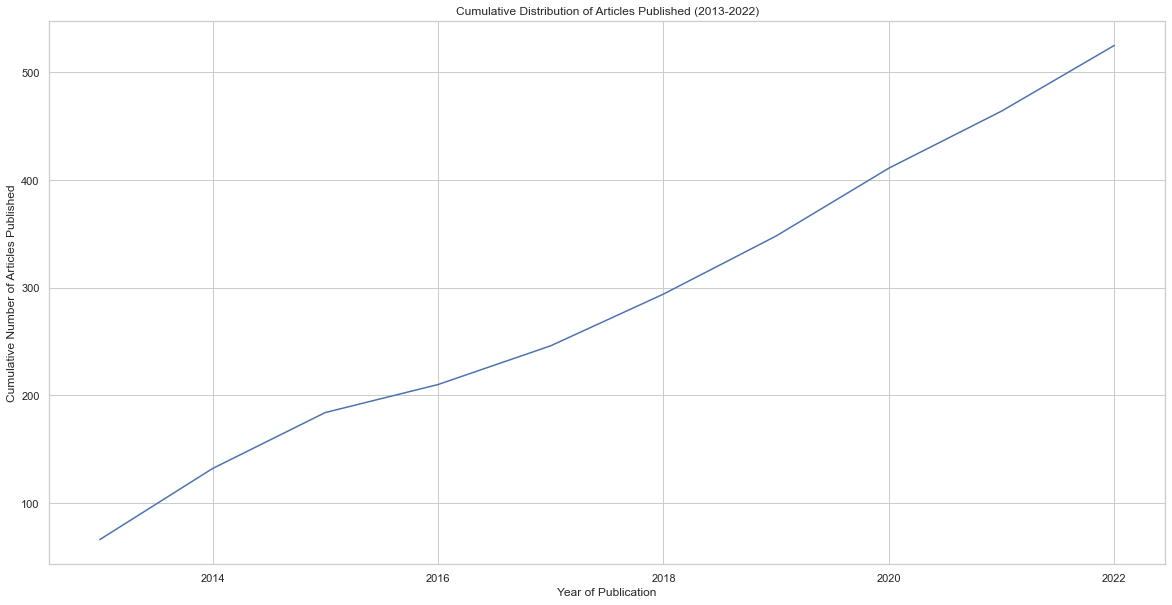

In [5]:
# Count the number of articles published in each year
year_counts = papers_data['Year of Publication'].value_counts().sort_index()

# Calculate the cumulative counts for each year
cumulative_counts = year_counts.cumsum()

# Create a bar plot or line plot showing the cumulative counts
plt.figure(figsize=(20, 10))
cumulative_counts.plot(kind='line')
plt.title('Cumulative Distribution of Articles Published (2013-2022)')
plt.xlabel('Year of Publication')
plt.ylabel('Cumulative Number of Articles Published')
plt.show()

From the plots above, we can observe a few trends regarding the frequency of publications in the LSE's Economics department between 2013 and 2022. The years 2013 and 2014 had the highest number of publications, with 66 papers each, which could indicate a peak in research output during this period. In 2015, the number of publications dropped to 52, and a more significant decline occurred in 2016, where the number of publications reached its lowest at 26.

Starting from 2017, there has been a gradual increase in the frequency of publications. The department published 36 papers in 2017, which further increased to 48 in 2018. In the subsequent years, we can observe a steady growth in the number of publications, with 54 papers in 2019, followed by 63 in 2020. However, there was a slight dip in 2021, with 53 publications. The number of publications rose again in 2022 to reach 61, showing an overall upward trend in research output since 2016. The variations in the number of publications may be attributed to factors such as changes in departmental priorities, available funding, and external factors affecting the academic environment.

### Section 3.2 Distribution of Citations

This section of the exploratory data analysis (EDA) focuses on understanding the distribution of citation counts for papers published by the LSE's Economics department between 2013 and 2022. By generating two types of plots, a violin plot and a series of histograms, the section aims to reveal patterns and trends in citation counts across different years. The violin plot provides an overview of the entire dataset, illustrating the distribution of citation counts per year and highlighting potential outliers or skewness. The histograms, created using FacetGrid, display the frequency distribution of citation counts within each year, making it easier to compare the shape and spread of these distributions across the time span.

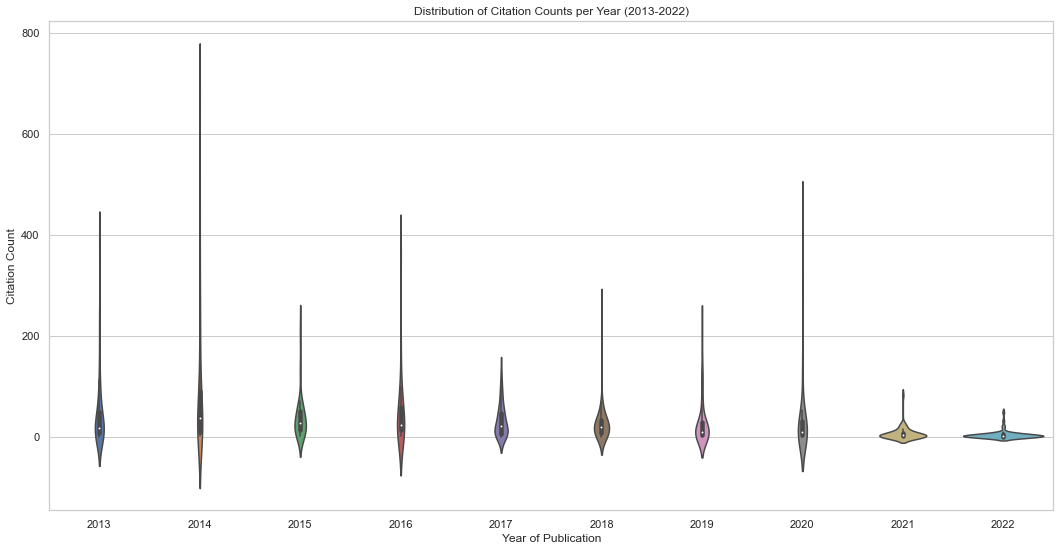

In [6]:
plt.figure(figsize=(18,9))
sns.violinplot(data=papers_data, x='Year of Publication', y='Citation Count')
plt.title('Distribution of Citation Counts per Year (2013-2022)')
plt.xlabel('Year of Publication')
plt.ylabel('Citation Count')
plt.show()

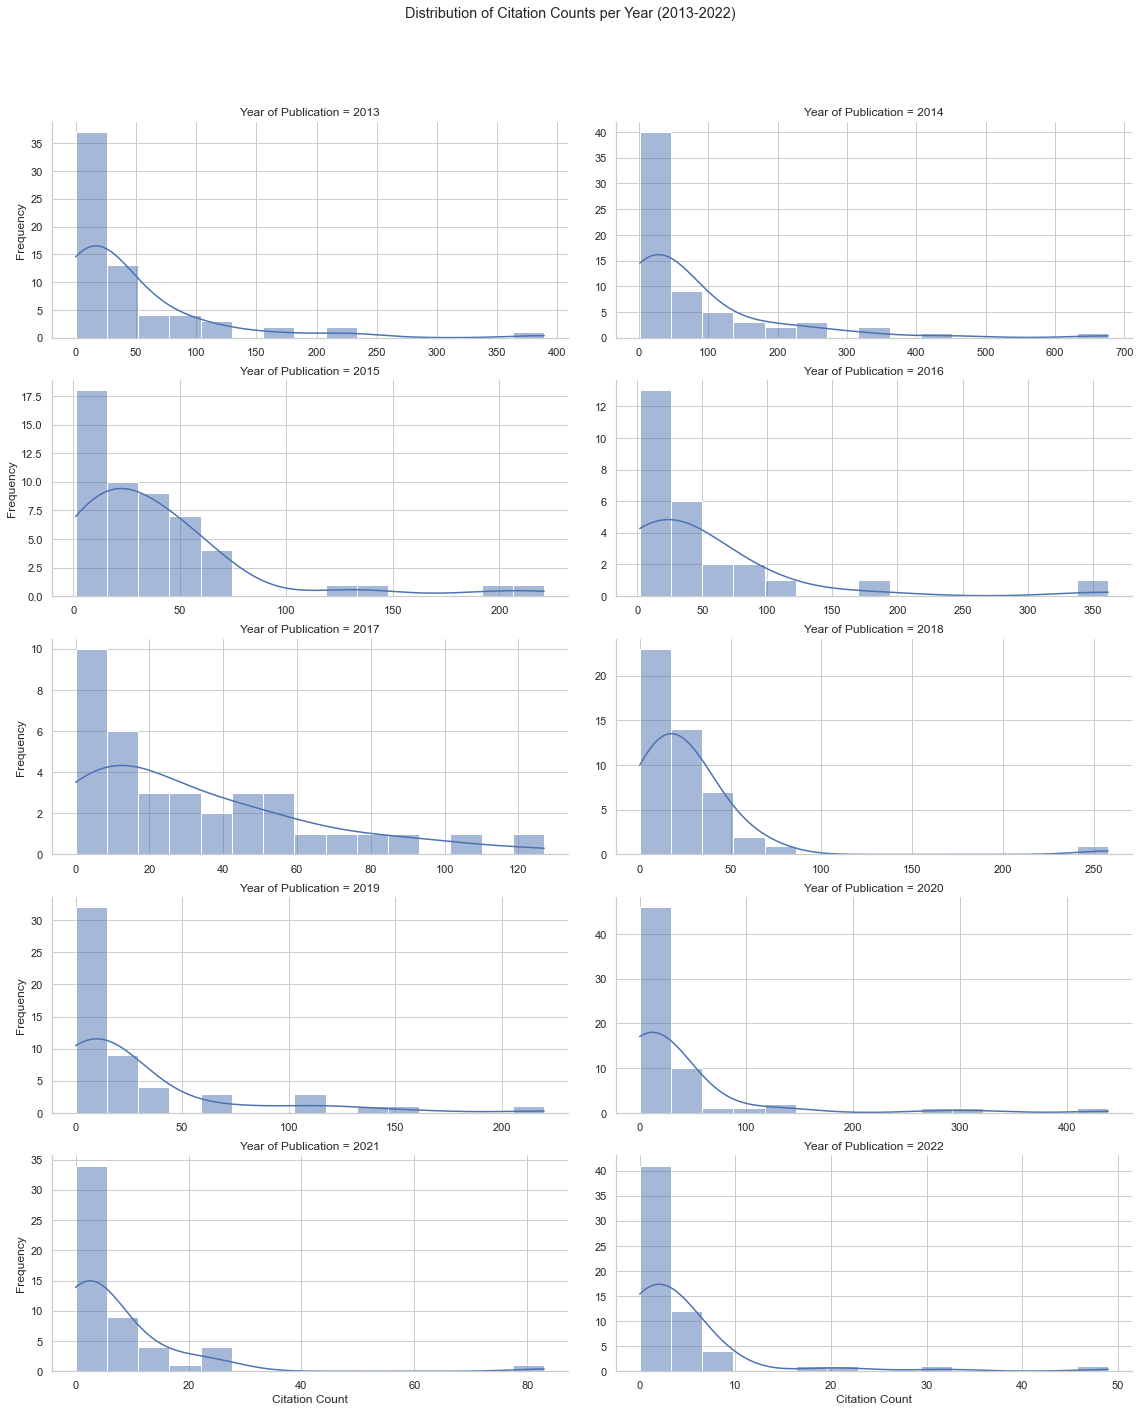

In [7]:

g = sns.FacetGrid(papers_data, col='Year of Publication', col_wrap=2, sharex=False, sharey=False, height=4, aspect=2)
g.map(sns.histplot, 'Citation Count', kde=True, bins=15)
g.set_axis_labels("Citation Count", "Frequency")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Citation Counts per Year (2013-2022)')
plt.show()

These plots provide insightful information on the distribution of citation counts by year for the LSE's Economics department between 2013 and 2022. Analyzing the data, we observe that the mean citation count has fluctuated throughout the years. In 2013, the mean citation count was 44.76, with a high standard deviation of 66.33, indicating significant variability in the citation counts. This variability is also reflected in the wide range of values, with a minimum of 0 and a maximum of 389.

In 2014, the mean citation count increased to 79.56, suggesting higher overall recognition for research published during that year. The standard deviation also rose to 118.07, indicating an even greater spread in the citation count values, possibly attributable to a few highly cited papers. The year 2014 also saw the highest maximum citation count of 677, indicating that at least one paper from the LSE Economics department had a substantial impact within the field.

From 2015 onwards, there was a decline in the mean citation count, reaching a low of 26.56 in 2018. This decline might be attributed to shifts in departmental focus, changes in the academic landscape, or the emergence of new research topics that garnered attention within the economics discipline. The standard deviations during these years were lower compared to the earlier years, indicating less variability in citation counts.

Interestingly, there was a notable increase in the mean citation count in 2016 (50.04) with a high standard deviation (74.77), which may suggest the presence of a few influential publications during this period. However, this increase was short-lived as the mean citation count continued to decline in the following years.

The years 2021 and 2022 witnessed the lowest mean citation counts, 7.04 and 4.34, respectively. The decline might be influenced by the fact that more recent publications have had less time to accumulate citations, as citation counts often grow over time. The standard deviations during these years were also considerably lower, suggesting a more uniform distribution of citation counts across papers.

Overall, the trends in citation count data for the LSE's Economics department reflect the dynamic nature of research impact and recognition. Factors such as shifts in research focus, the introduction of new research topics, or changes in the academic landscape can influence these trends. Further analysis of specific research topics and their relationship to citation counts, as well as a comparison with other institutions, could provide more context and deeper understanding of the underlying patterns.

### Section 3.3 Author Analysis

The "Author Analysis" section of this project aims to analyze the distribution of publications across individual authors. By splitting the "Authors" column in the "papers_data" dataset into separate names, creating a Series of authors, and then counting the number of publications for each author, the section provides an overview of the productivity of different authors in the field. The section then visualizes this information in the form of a bar plot, which helps to identify the authors with the highest number of publications. This analysis can be useful in identifying the most influential researchers in the field and understanding their impact on the research community.

count    1075.000000
mean        1.579535
std         2.009741
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        27.000000
dtype: float64
Author with the highest number of publications: John Van Reenen


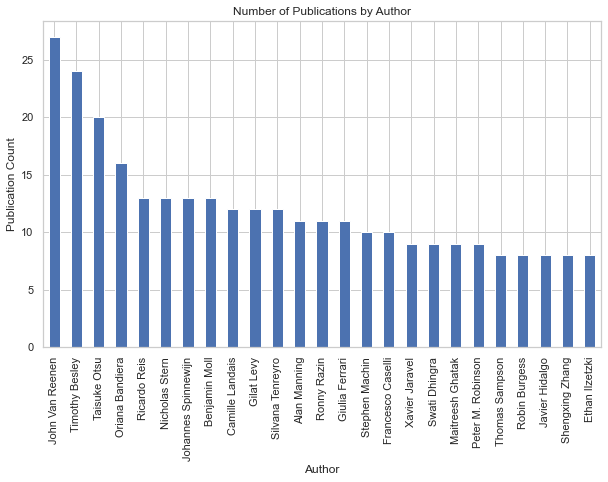

In [8]:
# Split the Authors column into separate names and create a Series of authors
authors = papers_data['Authors'].str.split(' and ', expand=True).stack().str.strip()

# Count the number of publications for each author
author_counts = authors.value_counts()

print(author_counts.describe())

# Print the author with the highest number of publications
print('Author with the highest number of publications:', author_counts.index[0])

import matplotlib.pyplot as plt

# Create a bar plot of the author publication counts
fig, ax = plt.subplots(figsize=(10,6))
author_counts.head(20).plot(kind='bar', ax=ax)

# Set the plot title and axis labels
ax.set_title('Number of Publications by Author')
ax.set_xlabel('Author')
ax.set_ylabel('Publication Count')

# Show the plot
plt.show()

The given data presents some insights into the distribution of publications by author. The mean number of publications per author is 1.58, with a standard deviation of 2.01, indicating that there is a wide range of variation in the number of publications among authors. The maximum number of publications by an author is 27, while the minimum is 1. The top 20 publishers have published a significant number of papers, with John Van Reenen leading the pack with 27 publications, followed by Timothy Besley with 24, and Taisuke Otsu with 20. This suggests that some authors are more prolific than others, and some topics or fields of study may attract more attention and publication than others. On the other hand, the bottom 20 publishers have only published one paper each, which may indicate that they are either relatively new to the field or less established. However, it is important to note that the number of publications does not necessarily reflect the quality of the research or the impact it has had. Overall, these statistics provide a broad overview of the distribution of publications among authors, but further analysis would be necessary to draw more specific conclusions about the trends and patterns in this data.

## Section 4: Insights, Limitations and Conclusions

This research project aimed to analyze the research output of the LSE Economics department between 2013 and 2022. Based on the exploratory data analysis, we can draw several insights and conclusions about the department's productivity, trends in citations, and the contributions of individual authors.

### 4.1 Insights

1. *Research Output*: The volume and growth of research output exhibited a fluctuating pattern, with a peak in 2013 and 2014, followed by a significant decline in 2016. Since then, there has been a steady upward trend in the number of publications. This information can be useful for LSE's internal resource allocation and strategic planning.

2. *Citation Trends*: The distribution of citation counts showed variability across the years, with some years, such as 2014, having a high mean citation count, while others experienced a decline. Recent publications (2021 and 2022) have had lower citation counts, likely due to their recency. This analysis can inform future research focus, collaboration efforts, and funding opportunities for LSE's Economics department.

3. *Author Contributions*: The analysis of individual authors revealed that some members of the department, like John Van Reenen, Timothy Besley, and Taisuke Otsu, have made significant contributions to the department's research output. The diverse distribution of publications among authors indicates that some researchers may be more prolific or specialized in certain areas.

### 4.2 Limitations

While this project provides valuable insights into LSE's Economics department's research output, there are some limitations to consider:

1. *Citation Counts*: Using citation counts as a measure of research impact has its shortcomings. It may not accurately reflect the quality of research or its real-world impact, as some publications with low citation counts might have a significant influence on policy or industry.

2. *Data Source*: The data used in this analysis may not include all publications or accurately represent their citations. Some publications might have been missed or misattributed, and citation counts may vary between databases.

3. *Time Frame*: This study focused on a specific time frame (2013-2022), and the trends observed may not hold true for other periods. Additionally, the analysis of more recent publications may be affected by their recency and the limited time available to accumulate citations.

4. *External Factors*: The analysis does not account for external factors that may have influenced research output, such as economic or political events, changes in funding, or broader academic trends in economics research.

### 4.3 Conclusions

This research project aimed to analyze the research output of the LSE Economics department from 2013 to 2022, addressing key research questions and motivations. The insights gained from this analysis can be used for academic impact assessment, benchmarking, and stakeholder engagement. Moreover, the analysis highlights the significant contributions of individual researchers, providing an opportunity for recognition and potential collaboration.

Despite the limitations mentioned above, I hope that this project has successfully contributed to a better understanding of the LSE Economics department's research output and impact over the years. The insights gained can serve as a valuable starting point for further research and can inform the department's future strategies, ensuring its continued success in advancing economic knowledge.